## VAE

In [1]:
import numpy as np
import torch
import os
from torch import optim
from torch.utils.data import DataLoader, TensorDataset

from models.ResVAE import ResVariationalAutoEncoder
from utils.load import load_cw, load_from_img, load_from_dir
from copy import deepcopy
from matplotlib import pyplot as plt
from utils.geodesicwelding import geodesicwelding

# from utils.get_kl_rate import get_kl_rate

In [2]:
img_dir = 'data/img/BW fish'

cw, data = load_from_dir(img_dir, 500, 100)

BW1.jpg
BW10.jpg
BW11.jpg
BW12.jpg
BW13.jpg
BW15.jpg
BW16.jpg
BW17.jpg
BW18.jpg
BW19.jpg
BW2.jpg
BW20.jpg
BW21.jpg
BW22.jpg
BW23.jpg
BW24.jpg
BW25.jpg
BW3.jpg
BW4.jpg
BW5.jpg
BW6.jpg
BW7.jpg
BW8.jpg
BW9.jpg


In [296]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
MAT_PATH = "data/preprocessed.theta.mat"
MODEL_SAVE_PATH = "checkpoints/ResVAE.pth"
SEED = 717

INPUT_DIM = 100  # Adjusted input dimension to match your complex data
H_DIM = 1000
Z_DIM = 2
H_LAYERS = [2,2]

NUM_EPOCHS = 10000
BATCH_SIZE = 64  # Adjusted batch size
LR_RATE = 1e-4
KL_RATE = 1
TRUE_RATE = 1

torch.manual_seed(SEED)
np.random.seed(SEED)

In [297]:
# cw = load_cw(MAT_PATH, ["Case00"])
# cw = np.stack([data[img_name][0] for img_name in data])
print(cw.shape)
cw_tensor = torch.tensor(cw)

train_data = TensorDataset(cw_tensor)
train_loader = DataLoader(
    dataset=train_data, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True
)

## Init model
model = ResVariationalAutoEncoder(
    input_dim=INPUT_DIM, h_dim=H_DIM, h_layers=H_LAYERS, z_dim=Z_DIM
).to(DEVICE)
model.initial()

## Load model
# model = torch.load('VAE_theta+bias1.pth')

optimizer = optim.Adam(
    model.parameters(), lr=LR_RATE, weight_decay=1e-5, betas=(0.5, 0.999)
)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10000], gamma=0.5)

model.to(DEVICE)

loader_size = len(train_loader)
loss_list_dict = {}

(24, 100)


In [298]:
model.train()

best_loss = 1e9

for epoch in range(NUM_EPOCHS):
    for i, [input_data] in enumerate(train_loader):
        input_data = input_data.to(DEVICE, dtype=torch.float32).view(input_data.shape[0], INPUT_DIM)
        x_reconstructed, mu, sigma = model(input_data)

        # Compute loss
        # kl_rate = get_kl_rate(epoch)
        kl_rate = KL_RATE
        true_rate = TRUE_RATE
        loss_dict = model.loss(x_reconstructed, input_data, mu, sigma, kl_rate, true_rate)

        # Backprop
        optimizer.zero_grad()
        loss_dict["loss"].backward()
        optimizer.step()
        scheduler.step()

        # Append losses to the lists
        for k, v in loss_dict.items():
            if k not in loss_list_dict:
                loss_list_dict[k] = np.zeros(loader_size)

            loss_list_dict[k][i] = v.item()

    if best_loss > loss_dict["loss"].item():
        best_loss = loss_dict["loss"].item()
        print(
            f"Best epoch {epoch}/{NUM_EPOCHS} | {', '.join([f'{k}: {v.mean():.4f}' for k, v in loss_list_dict.items()])}"
        )
        best_params = deepcopy(model.state_dict())
        # torch.save(model.state_dict(), MODEL_SAVE_PATH)
    # torch.save(model, 'checkpoints/best_ResVAE.pth')
    # Calculate and print average losses for this epoch
    # avg_loss = loss_list.sum() / data_size
    # avg_recon_loss = recon_loss_list.sum() / data_size
    # avg_kl_loss = kl_loss_list.sum() / data_size
    # avg_loss = loss_list.mean()
    # avg_recon_loss = recon_loss_list.mean()
    # avg_kl_loss = kl_loss_list.mean()
    # avg_true_loss = true_loss_list.mean()

    if epoch % 100 == 0:
        print(
            f"Epoch {epoch}/{NUM_EPOCHS} | {', '.join([f'{k}: {v.mean():.4f}' for k, v in loss_list_dict.items()])}"
        )

    # if epoch % 1000 == 0:
    #     torch.save(model, "checkpoints/ResVAE.pth")

torch.save(best_params, 'checkpoints/ResVAE.pth')

Best epoch 0/10000 | loss: 3624.5454, recon_loss: 3379.0388, kl_loss: 107.7820, true_loss: 137.7247
Epoch 0/10000 | loss: 3624.5454, recon_loss: 3379.0388, kl_loss: 107.7820, true_loss: 137.7247
Best epoch 1/10000 | loss: 2458.3779, recon_loss: 2339.5681, kl_loss: 24.2257, true_loss: 94.5844
Best epoch 2/10000 | loss: 2076.5908, recon_loss: 1933.7449, kl_loss: 91.8368, true_loss: 51.0091
Best epoch 3/10000 | loss: 1841.6089, recon_loss: 1469.1670, kl_loss: 138.9462, true_loss: 233.4958
Best epoch 4/10000 | loss: 1401.3121, recon_loss: 1238.5081, kl_loss: 136.4316, true_loss: 26.3724
Best epoch 5/10000 | loss: 1124.0509, recon_loss: 929.4708, kl_loss: 107.0724, true_loss: 87.5076
Best epoch 6/10000 | loss: 991.3817, recon_loss: 795.0481, kl_loss: 81.8671, true_loss: 114.4665
Best epoch 8/10000 | loss: 889.9732, recon_loss: 801.8695, kl_loss: 44.8660, true_loss: 43.2377
Best epoch 9/10000 | loss: 786.7344, recon_loss: 698.3220, kl_loss: 30.5001, true_loss: 57.9124
Best epoch 10/10000 | l

In [299]:
# torch.load(best_params, 'checkpoints/ResVAE.pth')
model.load_state_dict(best_params)
# for i, [input_data] in enumerate(train_loader):
#     input_data = input_data.to(DEVICE, dtype=torch.float32).view(input_data.shape[0], INPUT_DIM)
#     x_reconstructed, mu, sigma = model(input_data)

#     kl_rate = KL_RATE
#     loss_dict = model.loss(x_reconstructed, input_data, mu, sigma, kl_rate)

#     # Append losses to the lists
#     for k, v in loss_dict.items():
#         if k not in loss_list_dict:
#             loss_list_dict[k] = np.zeros(loader_size)

#         loss_list_dict[k][i] = v.item()

# print(
#     f"{', '.join([f'{k}: {v.mean():.4f}' for k, v in loss_list_dict.items()])}"
# )

<All keys matched successfully>

Generate Data

In [300]:
def generate(num=1, mu_vals=None, sigma_vals=None, z_dim=Z_DIM):
    if mu_vals is None:
        mu = torch.zeros(1, z_dim).to(DEVICE, dtype=torch.float)
    else:
        mu = torch.tensor(mu_vals).to(DEVICE, dtype=torch.float).view(1, z_dim)

    if sigma_vals is None:
        sigma = torch.ones(1, z_dim).to(DEVICE, dtype=torch.float)
    else:
        sigma = torch.tensor(sigma_vals, dtype=torch.float).to(DEVICE).view(1, z_dim)

    generated_data = []

    model.eval()
    with torch.no_grad():
        for _ in range(num):
            z = model.sample(mu, sigma)
            out = model.decode(z)
            generated_data.append(out)

    # Convert the generated data to a numpy array
    generated_data = torch.cat(generated_data, dim=0)

    return generated_data.cpu().detach().numpy()


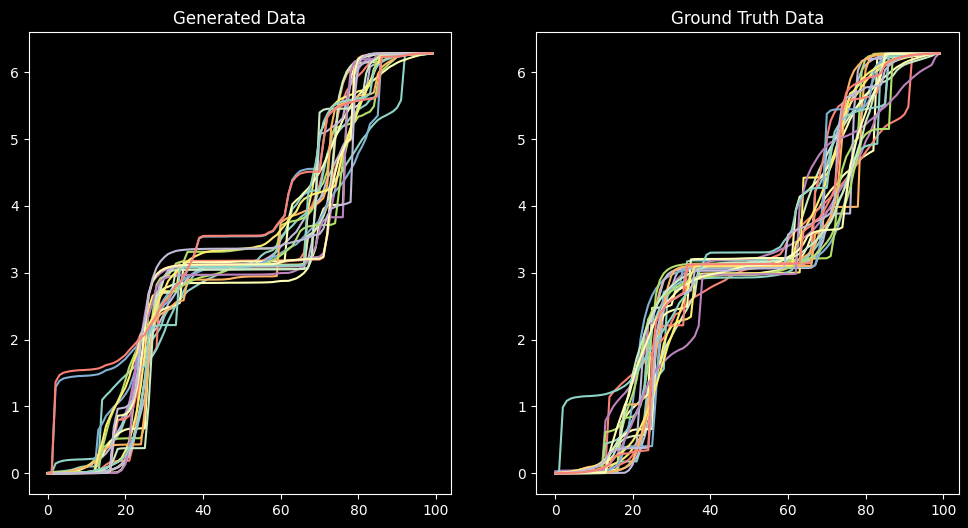

In [301]:
n = min(100, cw.shape[0])

# generated_data = h.view(-1, 100).cpu().detach().numpy()
diff = generate(num=n, mu_vals=np.repeat(0, Z_DIM), sigma_vals=np.repeat(2, Z_DIM))
diff = 1 / (np.exp(diff) + 1e-6)
diff = diff / diff.sum(axis=1, keepdims=True) * 2 * np.pi
angle = np.cumsum(diff, axis=1)

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(121)
ax.title.set_text("Generated Data")
for i in range(angle.shape[0]):
    ax.plot(angle[i])

ground_truth_diff = cw[np.sort(np.random.choice(range(cw.shape[0]), n, replace=False))]
ground_truth_diff = 1 / (np.exp(ground_truth_diff) + 1e-6)
ground_truth_diff = (
    ground_truth_diff / ground_truth_diff.sum(axis=1, keepdims=True) * 2 * np.pi
)
ground_truth_angle = np.cumsum(ground_truth_diff, axis=1)

ax = fig.add_subplot(122)
ax.title.set_text("Ground Truth Data")
for i in range(ground_truth_angle.shape[0]):
    ax.plot(ground_truth_angle[i])

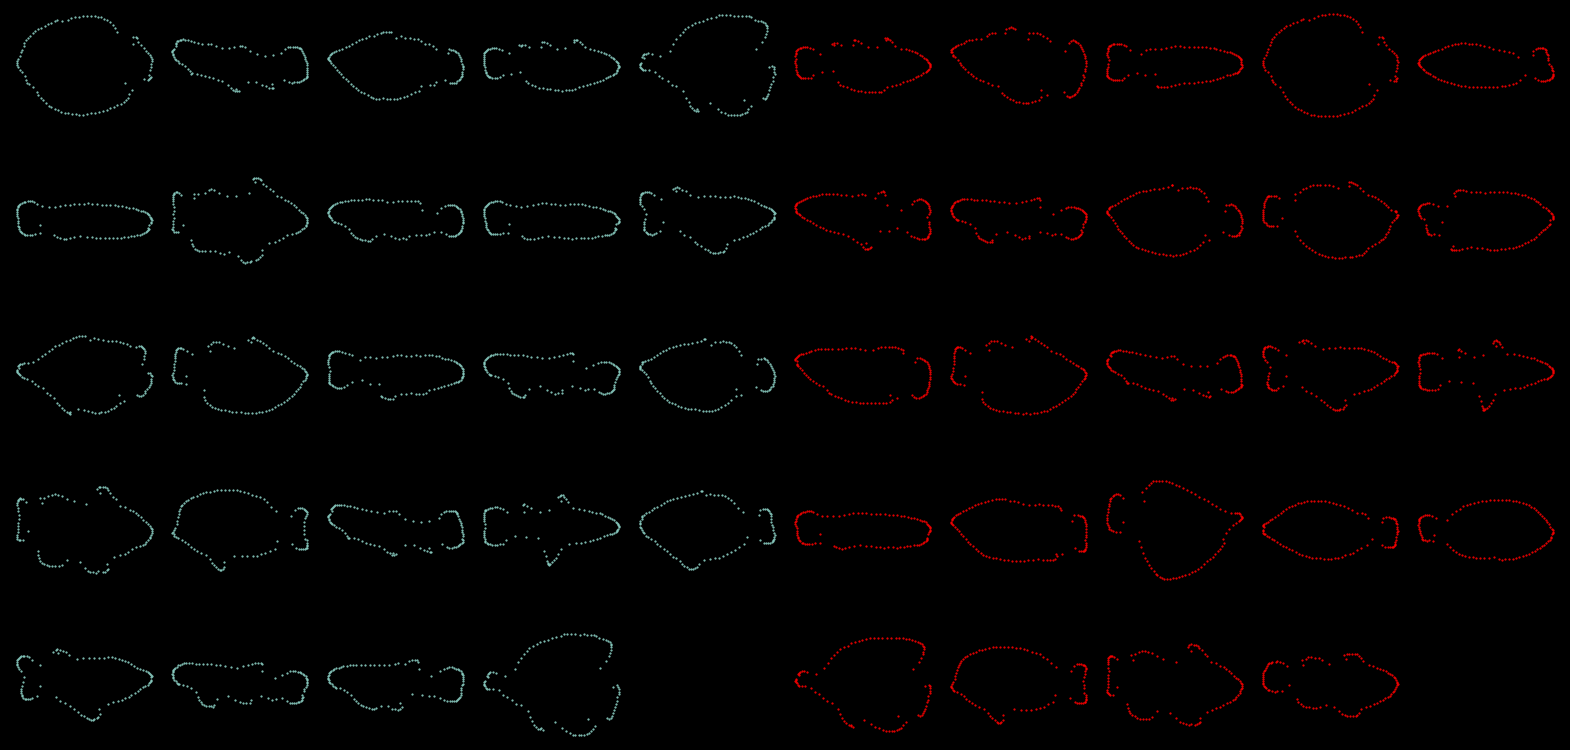

In [302]:
x = np.linspace(0, 2 * np.pi, INPUT_DIM + 1)[:INPUT_DIM]
xs = np.exp(1j * x)

x_num = 5
y_num = int(np.floor(2 * n / x_num))
subfigure_size = 2
fig = plt.figure(figsize=(2 * x_num * subfigure_size, y_num * subfigure_size))
fig.subplots_adjust(hspace=0.05, wspace=0.05)

# Blue for generated data
for i in range(n):
    ys = np.exp(1j * angle[i])
    try:
        r, _ = geodesicwelding(ys, [], ys, xs)
    except:
        pass
    k = i // x_num * 2 * x_num + i % x_num + 1
    plt.subplot(y_num, 2 * x_num, k)
    plt.gca().set_aspect("equal", adjustable="box")
    plt.scatter(r.real, r.imag, s=0.3)
    plt.axis("off")

# Red for ground truth data
for i in range(n):
    ys = np.exp(1j * ground_truth_angle[i])
    try:
        r, _ = geodesicwelding(ys, [], ys, xs)
    except:
        pass
    k = i // x_num * 2 * x_num + i % x_num + 1 + x_num
    plt.subplot(y_num, 2 * x_num, k)
    plt.gca().set_aspect("equal", adjustable="box")
    plt.scatter(r.real, r.imag, s=0.3, color="r")
    plt.axis("off")

Analysis

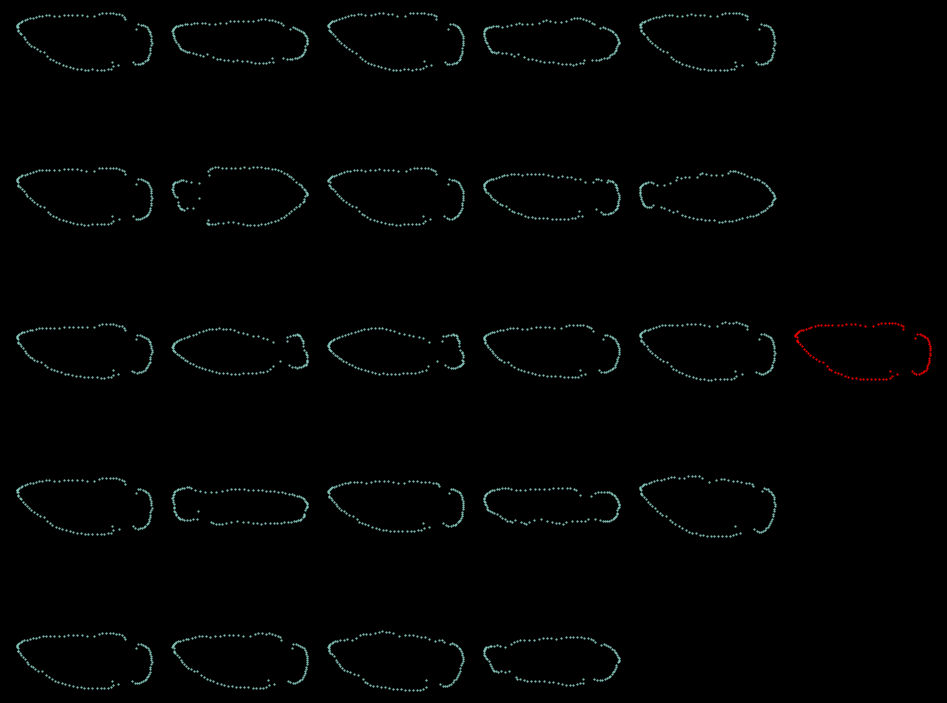

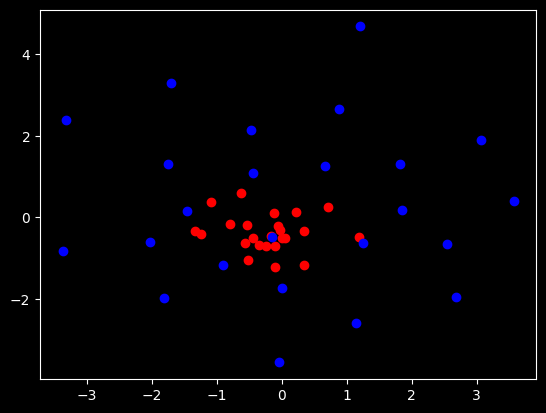

In [361]:
nk = 10

mu, log_var = model.encode(cw_tensor.to(DEVICE, dtype=torch.float32))
# eps = 0.6 * torch.randn_like(mu)
z0 = mu + log_var.exp().sqrt()
z1 = torch.repeat_interleave(z0[nk].view(1, -1), n, dim=0)
eps = 0.5 * torch.randn_like(z1)
z = z1 + eps
h = model.decode(z)
y = model.reconstruct(h)
y = y.cpu().detach().numpy()
# for each in x.cpu().detach().numpy():
#     plt.plot(each)

fig = plt.figure(figsize=(2 * x_num * subfigure_size, y_num * subfigure_size))
fig.subplots_adjust(hspace=0.05, wspace=0.05)

n = len(y)
for i in range(n):
    ys = np.exp(1j * y[i])
    try:
        r, _ = geodesicwelding(ys, [], ys, xs)
    except:
        pass
    k = i // x_num * 2 * x_num + i % x_num + 1
    plt.subplot(y_num, 2 * x_num, k)
    plt.gca().set_aspect("equal", adjustable="box")
    plt.scatter(r.real, r.imag, s=0.3)
    plt.axis("off")
    
for i in range(nk, nk+1):
    ys = np.exp(1j * ground_truth_angle[i])
    try:
        r, _ = geodesicwelding(ys, [], ys, xs)
    except:
        pass
    k = i // x_num * 2 * x_num + i % x_num + 1 + x_num
    plt.subplot(y_num, 2 * x_num, k)
    plt.gca().set_aspect("equal", adjustable="box")
    plt.scatter(r.real, r.imag, s=0.3, color="r")
    plt.axis("off")

plt.show()

z = z.cpu().detach().numpy()
z0 = mu + log_var.exp().sqrt()
z0 = z0.cpu().detach().numpy()
plt.scatter(z[:, 0], z[:, 1], color='r')
plt.scatter(z0[:, 0], z0[:, 1], color='b')

0.06283185307179587 0.1517817093764937


Text(0.5, 1.0, 'Original Distribution of Ground Truth ')

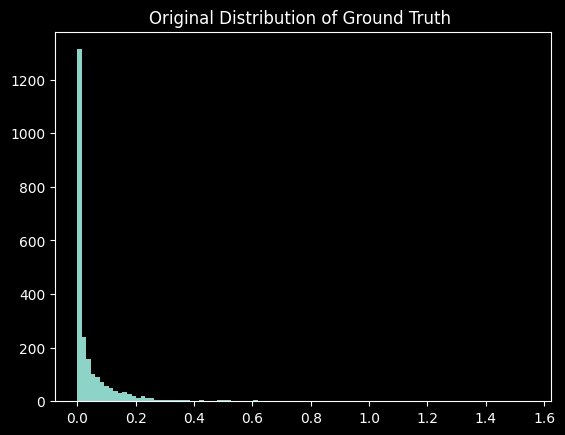

In [305]:
n = min(100, cw.shape[0])
c = cw[np.random.choice(range(cw.shape[0]), n, replace=False)]
p = 1 / np.exp(c)
print(p.mean(), p.std())
plt.hist(p.reshape(-1), bins=100)
plt.title("Original Distribution of Ground Truth ")

4.993474189620463 2.550422757360037


Text(0.5, 1.0, 'Distribution of Ground Truth Activated by 1/e^x')

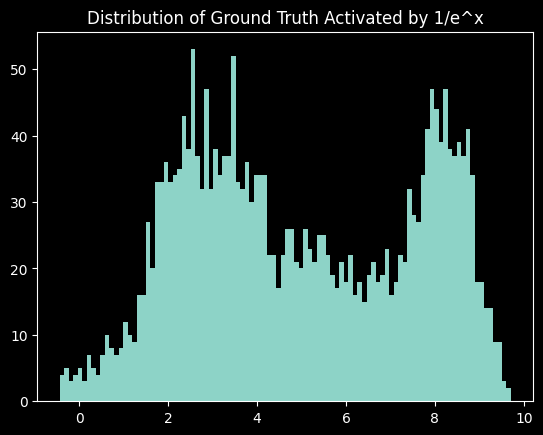

In [306]:
c = cw[np.random.choice(range(cw.shape[0]), n, replace=False)]
print(c.mean(), c.std())
plt.hist(c.reshape(-1), bins=100)
plt.title("Distribution of Ground Truth Activated by 1/e^x")

tensor(5.1827, device='cuda:0', grad_fn=<MeanBackward0>) tensor(2.4317, device='cuda:0', grad_fn=<StdBackward0>)


Text(0.5, 1.0, 'Distribution of Generated Data')

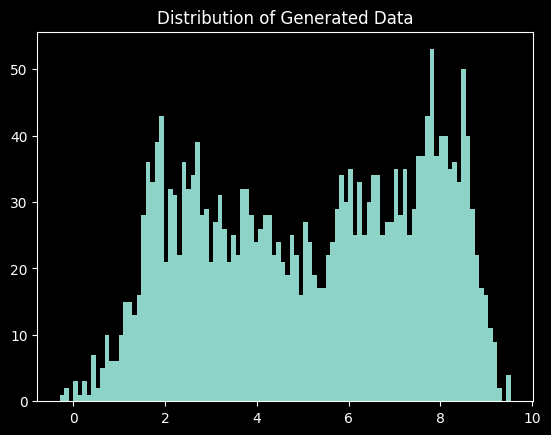

In [307]:
# print(model.mean, model.std)
z = torch.randn(n, Z_DIM).to(DEVICE).view(n, 1, Z_DIM)
h = model.decode(z)
print(h.mean(), h.std())
# h = 1/torch.exp(h+1e-8)
# h = h / torch.sum(h, dim=1, keepdim=True) * 2 * torch.pi
plt.hist(h.cpu().detach().numpy().reshape(-1), bins=100)
plt.title("Distribution of Generated Data")